# Regularized regression

**스케일에 민감하기 때문에 반드시 표준화 작업이 필요함**
* 정규화 (Ridge, Lasso, ElasticNet) 

    변수선택법의 대안으로 계수추정치들을 제한하거나 규칙화하는 기법으로 p개의 독립변수를 모두 포함하는 모델을 적합할 수 있다.

    모델에 규제항을 더해 기존 모델보다 단순하게 만듦

    회귀계수 값이 너무 커지는 것을 방지 -> 과적합 예방, 일반화 성능 향상

In [1]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

## EDA

In [37]:
# 부동산 시세 데이터
data= pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/house-prices/house_prices_train.csv')

data.head()



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [38]:
# 중복값, 결측치 확인
data.duplicated().sum()

0

In [39]:
# 결측치 개수 / 전체 개수
data.isna().sum()[data.isna().sum()!=0]/len(data)

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.597260
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

In [40]:
# 결측치가 80%가 넘는 컬럼 제거
cols = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
data.drop(cols, axis=1, inplace=True)

In [41]:
data.nunique()[data.nunique() > len(data)*0.7]

Id         1460
LotArea    1073
dtype: int64

In [42]:
# 고유값이 너무 많은 컬럼 제거
cols = ['Id', 'LotArea']
data.drop(cols, axis=1, inplace=True)

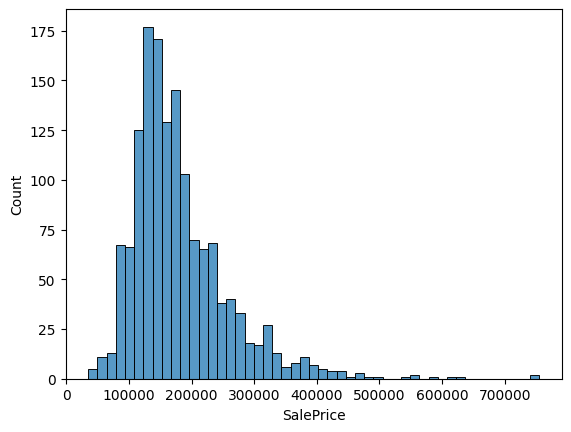

In [43]:
# 타겟 분포 확인
sns.histplot(data['SalePrice']);

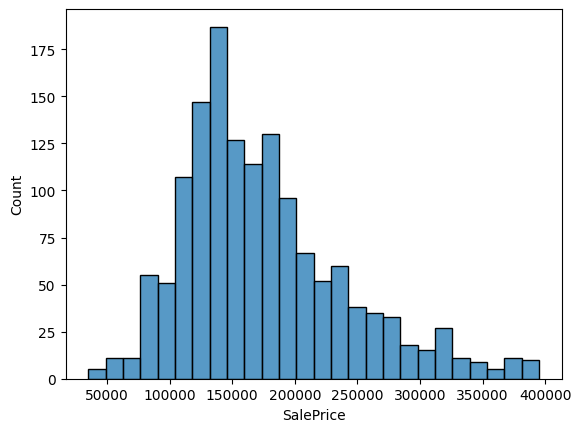

In [44]:
# 400000이하 데이터의 분포만 확인
df = data[data['SalePrice'] < 400000]
sns.histplot(df['SalePrice']);

In [45]:
# 수치형 컬럼(numeric_only=True)과 타겟간의 상관관계 확인
df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)[:10]

SalePrice       1.000000
OverallQual     0.794784
GrLivArea       0.663579
GarageCars      0.646759
GarageArea      0.624492
TotalBsmtSF     0.575020
1stFlrSF        0.564498
YearBuilt       0.558338
FullBath        0.556311
YearRemodAdd    0.538547
Name: SalePrice, dtype: float64

In [46]:
# 연도 관련 데이터 해당 연도가 아닌 현재연도와의 차이값으로 변경
print('가장 최근 연도:', df['YearBuilt'].max(), df['YearRemodAdd'].max())
df['YearBulit_d'] = 2011 - df['YearBuilt']
df['YearRemodAdd_d'] = 2011 - df['YearRemodAdd']

df.drop(['MoSold', 'YrSold', 'YearBuilt', 'YearRemodAdd'], axis=1, inplace=True)

가장 최근 연도: 2010 2010


In [47]:
df.sample(3)

,MSSubClass,MSZoning,LotFrontage,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition,SalePrice,YearBulit_d,YearRemodAdd_d
1448,50,RL,70.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,...,0,0,0,0,0,WD,Normal,112000,101,11
816,20,RL,NaN,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,120,0,0,0,0,WD,Normal,137000,57,57
77,50,RM,50.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,...,0,0,0,0,0,WD,Normal,127000,63,10


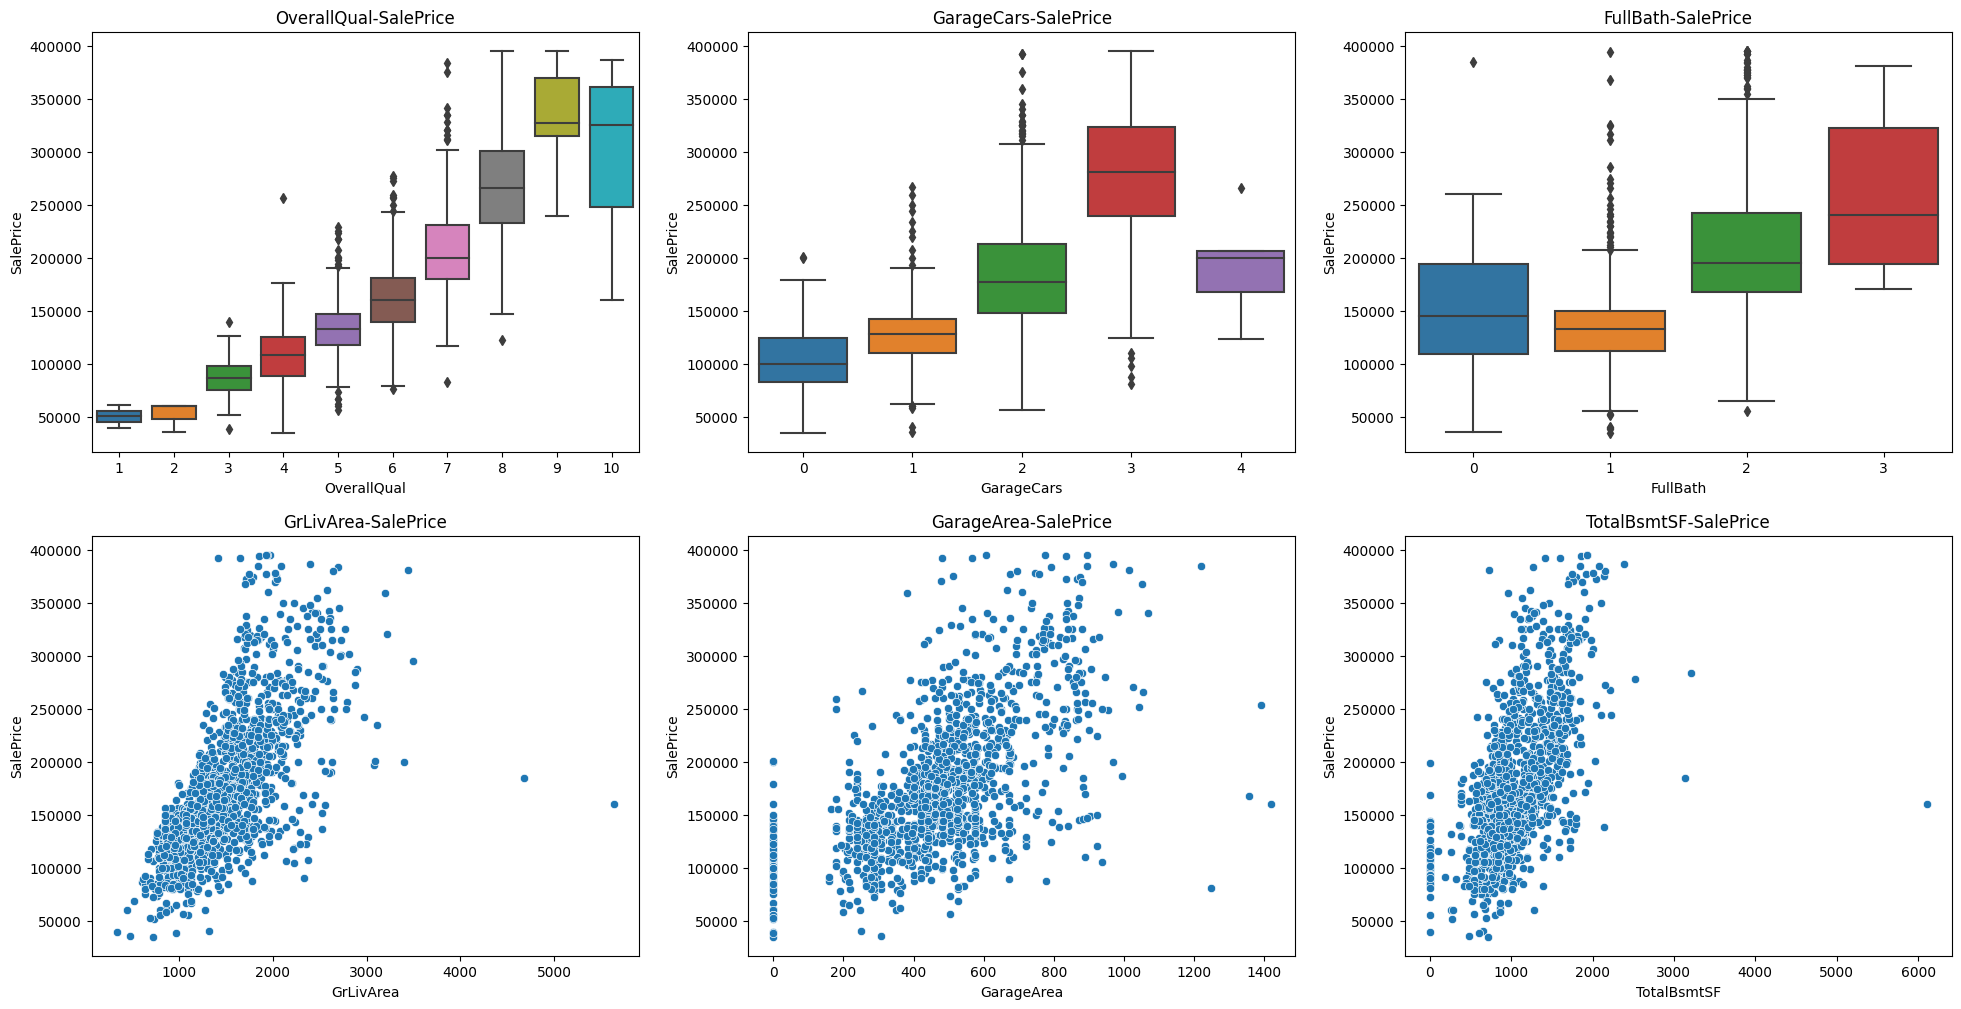

In [48]:
# 타겟과의 관계 시각화
cat = ['OverallQual', 'GarageCars', 'FullBath']
num = ['GrLivArea', 'GarageArea', 'TotalBsmtSF']
tar = 'SalePrice'
fig = plt.figure(figsize=(24,12)) # 전체 프레임 생성
(a1, a2, a3), (a4, a5, a6) = fig.subplots(nrows=2, ncols=3) # 2행 3열의 그래프 생성
## 범주형
sns.boxplot(data=df, x=cat[0], y=tar, ax=a1)
a1.set_title(f'{cat[0]}-{tar}')
sns.boxplot(data=df, x=cat[1], y=tar, ax=a2)
a2.set_title(f'{cat[1]}-{tar}')
sns.boxplot(data=df, x=cat[2], y=tar, ax=a3)
a3.set_title(f'{cat[2]}-{tar}')
## 수치형
sns.scatterplot(data=df, x=num[0], y=tar, ax=a4)
a4.set_title(f'{num[0]}-{tar}')
sns.scatterplot(data=df, x=num[1], y=tar, ax=a5)
a5.set_title(f'{num[1]}-{tar}')
sns.scatterplot(data=df, x=num[2], y=tar, ax=a6)
a6.set_title(f'{num[2]}-{tar}')

plt.show();

## 표준화, 인코딩

In [87]:
# 모델링
## 데이터 분할
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [88]:
## 수치형 변수만 결측치를 평균값으로 대체 후 표준화 진행
num_col = x_train.dtypes[x_train.dtypes != 'object'].index # 컬럼명들만 (idx: 컬럼명, value: dtype)
x_train[num_col] = x_train[num_col].fillna(x_train[num_col].mean())
x_test[num_col] = x_test[num_col].fillna(x_test[num_col].mean())
x_train[num_col].isna().sum()

MSSubClass        0
LotFrontage       0
OverallQual       0
OverallCond       0
MasVnrArea        0
BsmtFinSF1        0
BsmtFinSF2        0
BsmtUnfSF         0
TotalBsmtSF       0
1stFlrSF          0
2ndFlrSF          0
LowQualFinSF      0
GrLivArea         0
BsmtFullBath      0
BsmtHalfBath      0
FullBath          0
HalfBath          0
BedroomAbvGr      0
KitchenAbvGr      0
TotRmsAbvGrd      0
Fireplaces        0
GarageYrBlt       0
GarageCars        0
GarageArea        0
WoodDeckSF        0
OpenPorchSF       0
EnclosedPorch     0
3SsnPorch         0
ScreenPorch       0
PoolArea          0
MiscVal           0
YearBulit_d       0
YearRemodAdd_d    0
dtype: int64

In [55]:
scaler = StandardScaler() # 표준화
x_train[num_col] = scaler.fit_transform(x_train[num_col])
x_test[num_col] = scaler.transform(x_test[num_col])

In [62]:
## 표준화 확인
x_train_sc = x_train[num_col]
x_test_sc =  x_test[num_col]
x_train_sc.describe().T[['mean', 'std']] # 평균은 0, 표준편차는 1

,mean,std
MSSubClass,5.507482e-17,1.000437
LotFrontage,4.654210e-17,1.000437
OverallQual,-2.327105e-16,1.000437
OverallCond,2.544301e-16,1.000437
MasVnrArea,1.551403e-17,1.000437
BsmtFinSF1,-5.507482e-17,1.000437
BsmtFinSF2,-2.792526e-17,1.000437
BsmtUnfSF,1.148038e-16,1.000437
TotalBsmtSF,1.799628e-16,1.000437
1stFlrSF,1.396263e-16,1.000437


* encoding

    기본적으로 scikit-learn의 ML알고리즘은 문자열을 허락하지 않음

    때문에 모든 값은 숫자 형태로 인코딩하는 전처리 작업 필요

    * 레이블 인코딩 (숫자의 크고 작음이 적용된다는 단점! => 선형회귀XX)

        ```encoder = LabelEncoder()```

        기존값 확인

        ```encoder.classes_```
    * 원-핫 인코딩 (카디널리티가 높은 경우 벡터의 크기가 매우 커질 수 있음 => 차원의 저주!)

        테스트 데이터에 새로운 정보가 있으면 오류 발생

        ```encoder = OneHotEncoder()```

        ```pd.get_dummies(data)```



In [59]:
## One-Hot Encoding
cat = x_train.dtypes[x_train.dtypes == 'object'].index
ohe = OneHotEncoder()
x_train_ohe = ohe.fit_transform(x_train[cat])
x_test_ohe = ohe.transform(x_test[cat])
x_train_ohe

ValueError: Found unknown categories ['RRNn', 'PosA'] in column 9 during transform

## 기준모델 (평균값)

In [89]:
base = [y_train.mean()] * len(y_train)
base_r2 =  r2_score(y_train, base)
base_mae = mean_absolute_error(y_train, base)
print(f'''
      기준모델R2: {base_r2}
      기준모델MAE: {base_mae}''')


      기준모델R2: 0.0
      기준모델MAE: 51072.83653172136


In [61]:
def print_score(model):
    train = model.score(x_train_sc, y_train)
    test = model.score(x_test_sc, y_test)
    print(f'''
          학습 R2: 약{train.round(3)}
          테스트 R2: 약{test.round(3)}''')
    return train, test

## 다중 선형 회귀(OLS)


In [91]:
ols = LinearRegression()
ols.fit(x_train_sc, y_train)
ols_train, ols_test = print_score(ols)


          학습 R2: 약-3.393552345103569e+21
          테스트 R2: 약-4.606314439643823e+21


### 회귀계수 상위 10개 시각화

True


<Axes: >

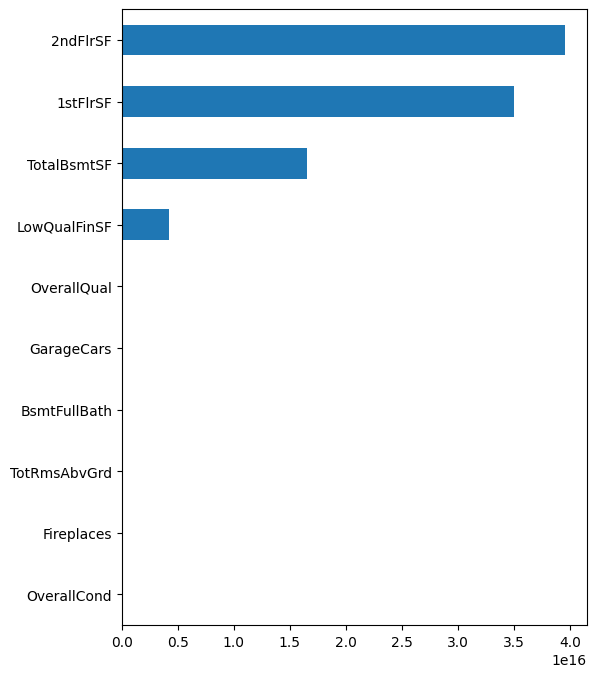

In [70]:
print(len(ols.coef_) == len(list(x_train_sc)))
ols_coef = pd.Series(ols.coef_, list(x_train_sc))
ols_coef.sort_values().tail(10).plot.barh(figsize=(6,8))

## Ridge

In [77]:
from sklearn.linear_model import RidgeCV # 교차검증 알고리즘
# 패널티값을 효율적으로 구하는 방법
alphas = np.arange(90, 100, 1)
ridge = RidgeCV(alphas=alphas, cv=5) # 알파값list, 교차검증 횟수
ridge.fit(x_train_sc, y_train)
# 최적 알파값
print("alpha: ", ridge.alpha_)
# 성능
rid_r2_tr, rid_r2_tt = print_score(ridge)

alpha:  99

          학습 R2: 약0.814
          테스트 R2: 약0.834


## Lasso
* Lasso 규제는 회귀계수가 0으로 수렴하여 변수를 선택하는 효과를 가지게 된다.

In [84]:
from sklearn.linear_model import LassoCV
alphas = np.arange(10, 200, 10)
lasso = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso.fit(x_train_sc, y_train)

print('alpha: ', lasso.alpha_)
las_r2_tr, las_r2_tt = print_score(lasso)

alpha:  190

          학습 R2: 약0.816
          테스트 R2: 약0.832


## 성능 비교

In [86]:
eval_compare = pd.DataFrame(index=['train', 'test'], \
    data={'OLS':[ols_train, ols_test], 'Ridge':[rid_r2_tr, rid_r2_tt], 'Lasso':[las_r2_tr, las_r2_tt]})
eval_compare

,OLS,Ridge,Lasso
train,0.815820,0.814018,0.815577
test,0.832236,0.833787,0.832225
